In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv("tips.csv")
df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [3]:
df.isnull().sum()

total_bill    0
tip           0
sex           0
smoker        0
day           0
time          0
size          0
dtype: int64

In [4]:
df = pd.get_dummies(df, columns=['sex', 'smoker', 'day', 'time'], drop_first=True)
df.head()

,total_bill,tip,size,sex_Male,smoker_Yes,day_Sat,day_Sun,day_Thur,time_Lunch
0,16.99,1.01,2,False,False,False,True,False,False
1,10.34,1.66,3,True,False,False,True,False,False
2,21.01,3.50,3,True,False,False,True,False,False
3,23.68,3.31,2,True,False,False,True,False,False
4,24.59,3.61,4,False,False,False,True,False,False


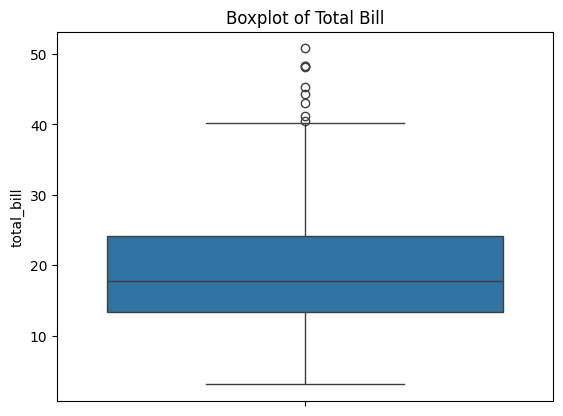

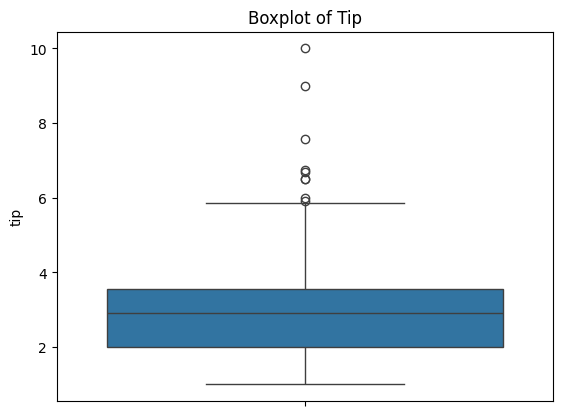

In [5]:
# Plotting boxplots to identify outliers
sns.boxplot(df['total_bill'])
plt.title('Boxplot of Total Bill')
plt.show()

sns.boxplot(df['tip'])
plt.title('Boxplot of Tip')
plt.show()

# Optionally remove outliers
Q1 = df['total_bill'].quantile(0.25)
Q3 = df['total_bill'].quantile(0.75)
IQR = Q3 - Q1

# Filtering out rows that are outliers in 'total_bill'
df = df[(df['total_bill'] >= (Q1 - 1.5 * IQR)) & (df['total_bill'] <= (Q3 + 1.5 * IQR))]

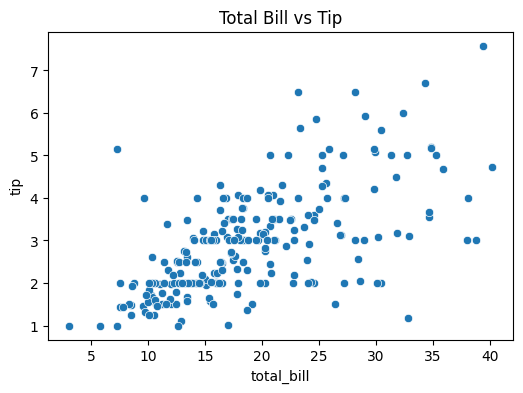

In [6]:
plt.figure(figsize=(6, 4))
sns.scatterplot(x='total_bill', y='tip', data=df)
plt.title("Total Bill vs Tip")
plt.show()

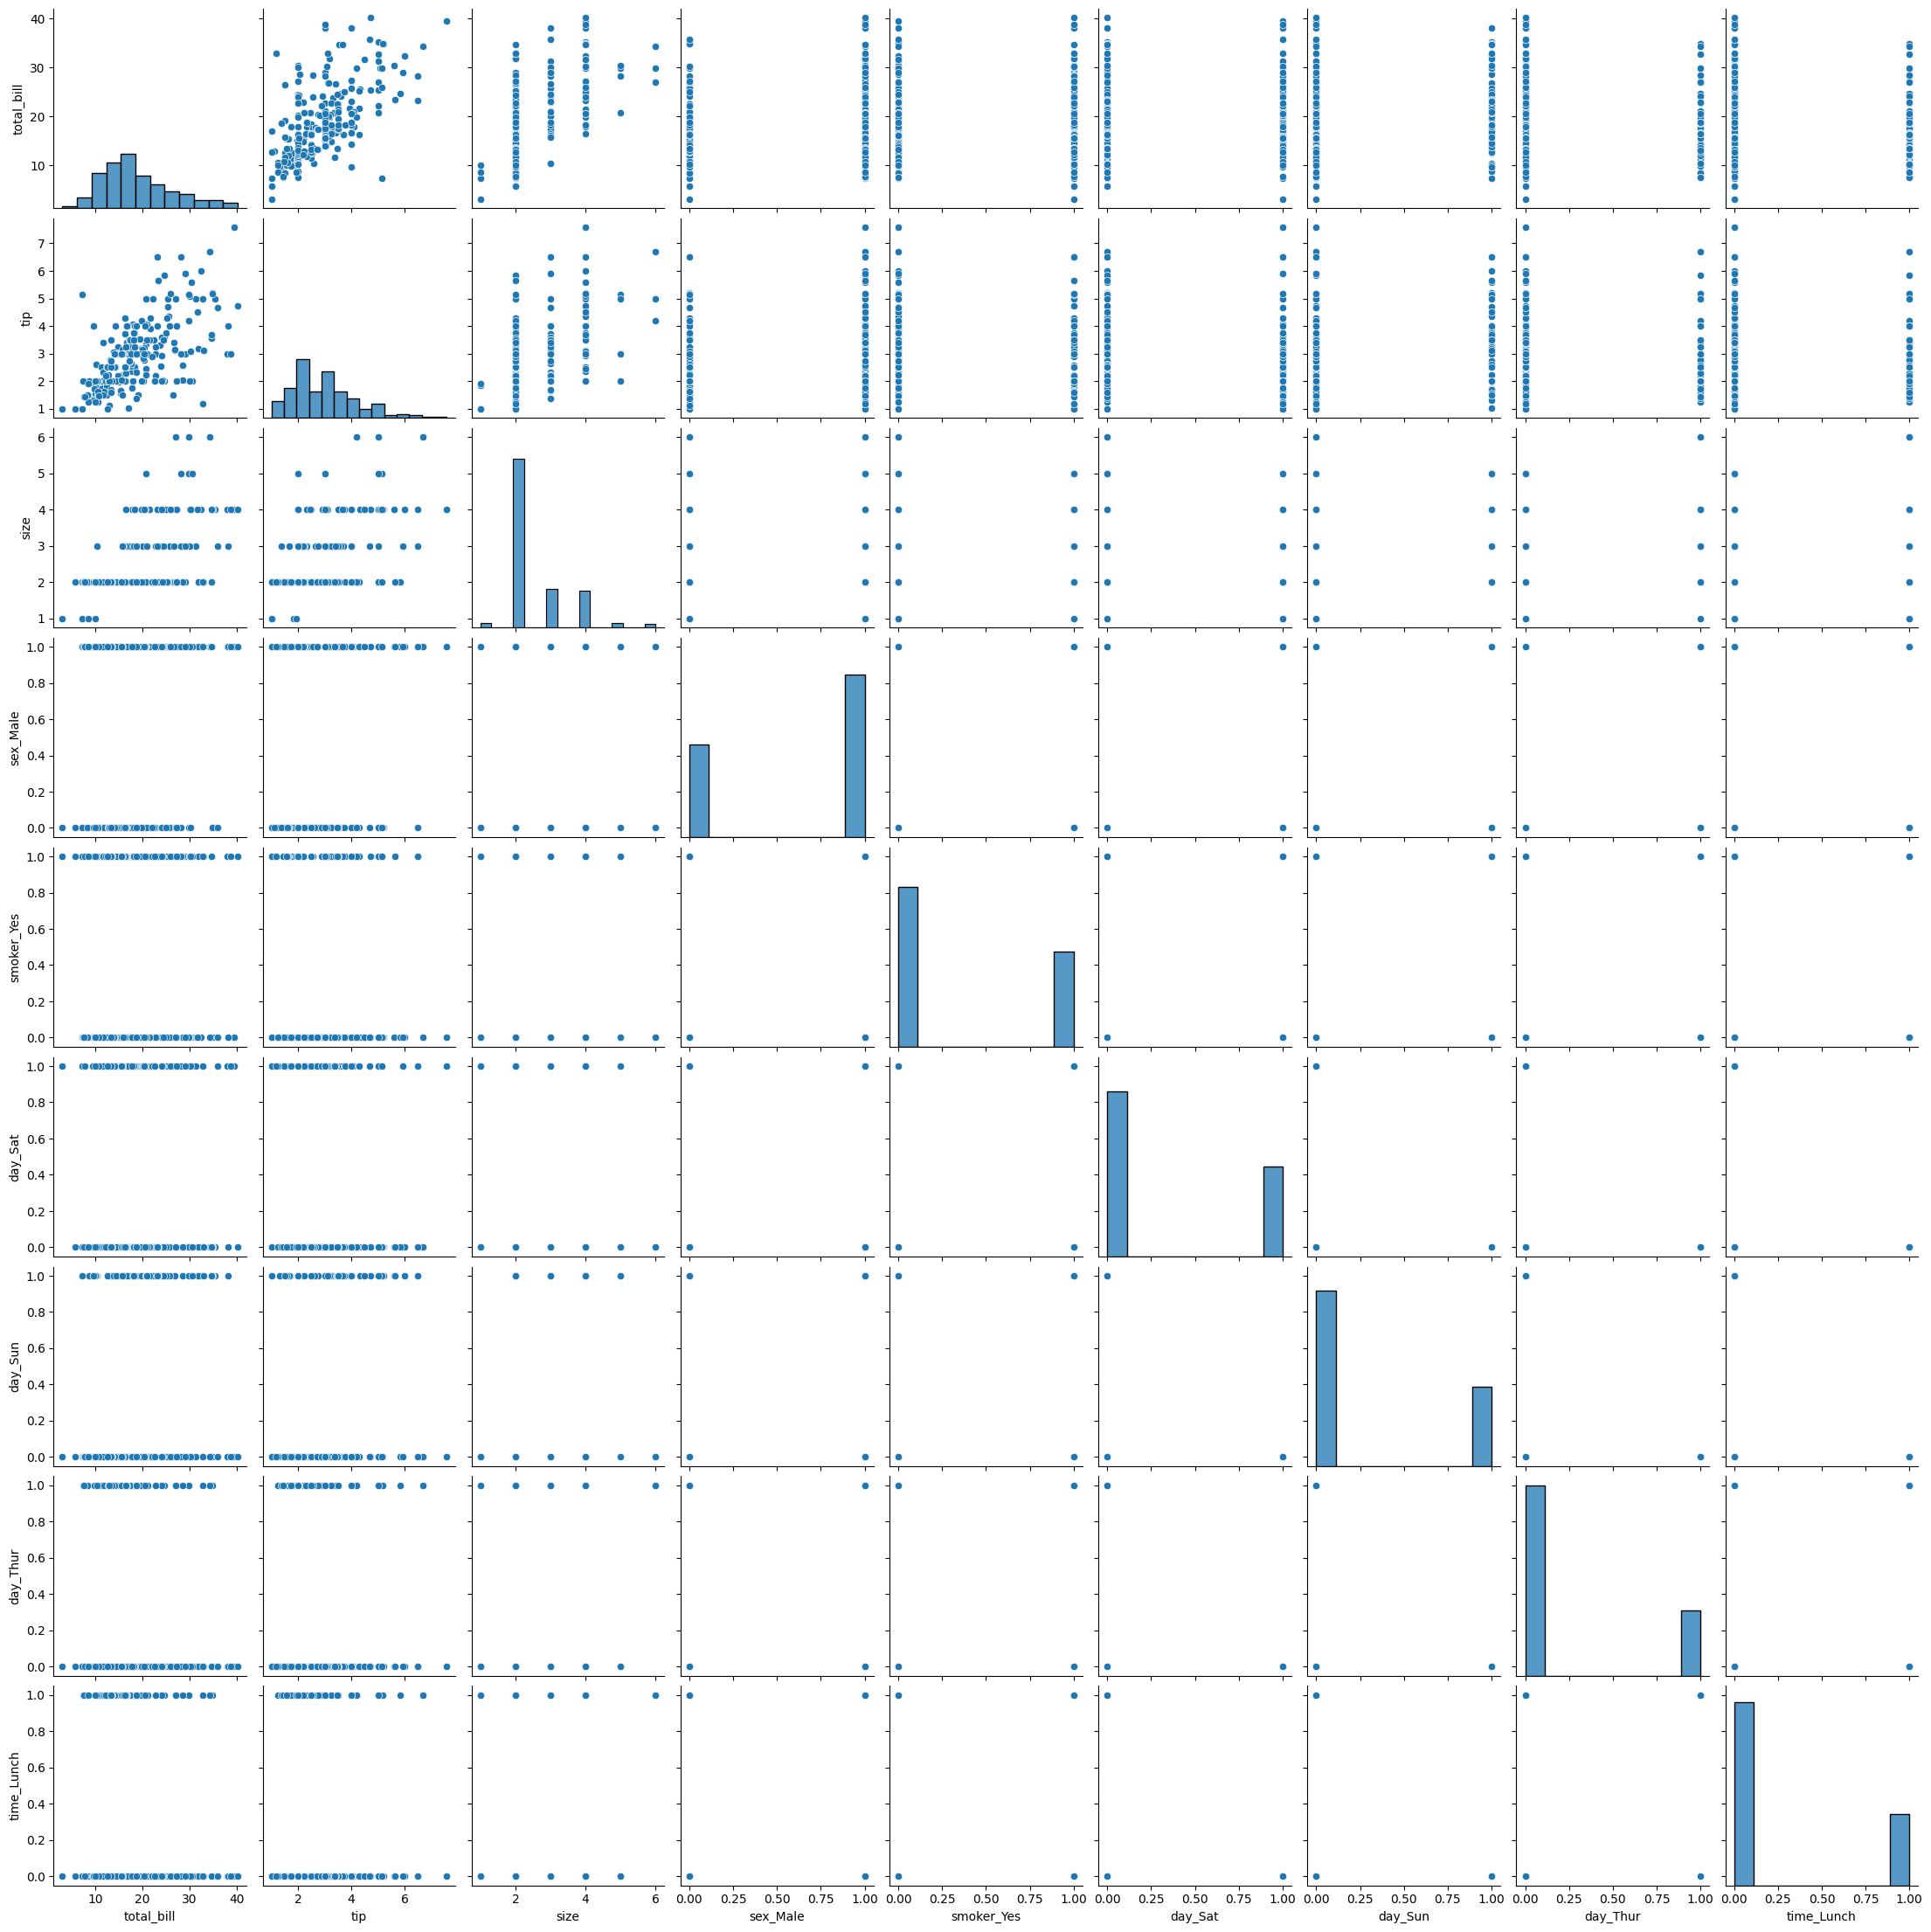

In [7]:
sns.pairplot(df)
plt.show()

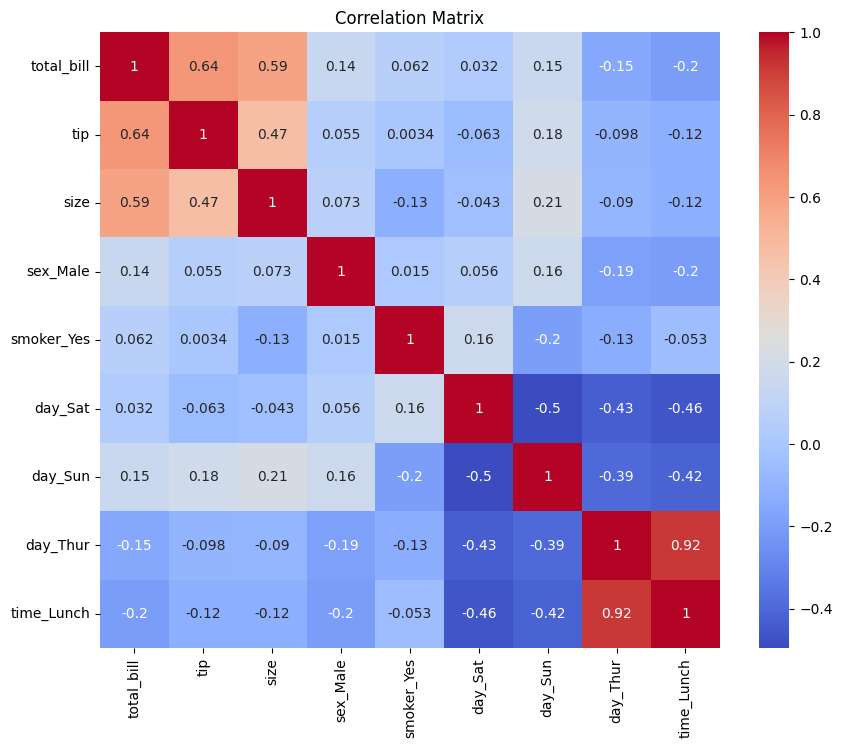

In [8]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [9]:
# Rainbow Test for Linearity
X = sm.add_constant(df['total_bill']) 
y = df['tip']
# Fitting an OLS regression model
model = sm.OLS(y, X).fit()
rainbow_stat, rainbow_p_value = sm.stats.linear_rainbow(model)
print(f"Rainbow Test Statistic: {rainbow_stat}")
print(f"Rainbow Test p-value: {rainbow_p_value}")

Rainbow Test Statistic: 1.6348917878789244
Rainbow Test p-value: 0.004264661794788288


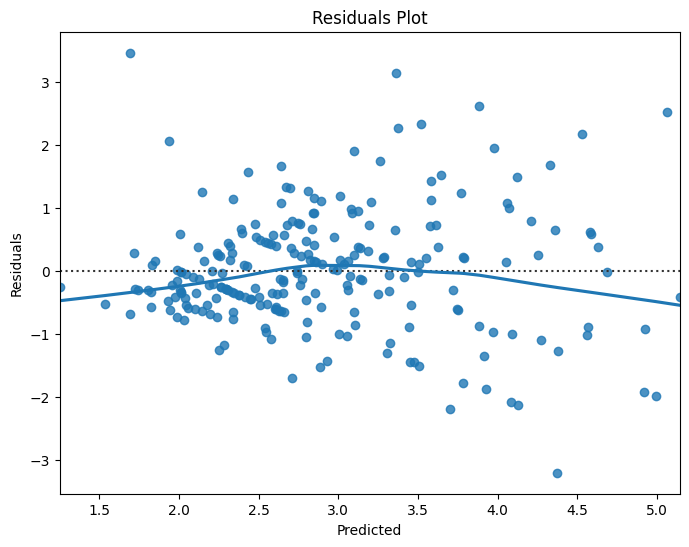

In [10]:
plt.figure(figsize=(8, 6))
sns.residplot(x=model.predict(X), y=y, lowess=True)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

In [11]:

if rainbow_p_value > 0.05:
    print("The null hypothesis is not rejected, suggesting that the model likely has a linear relationship.")
else:
    print("The null hypothesis is rejected, indicating that the model might not follow a linear pattern.")

The null hypothesis is rejected, indicating that the model might not follow a linear pattern.


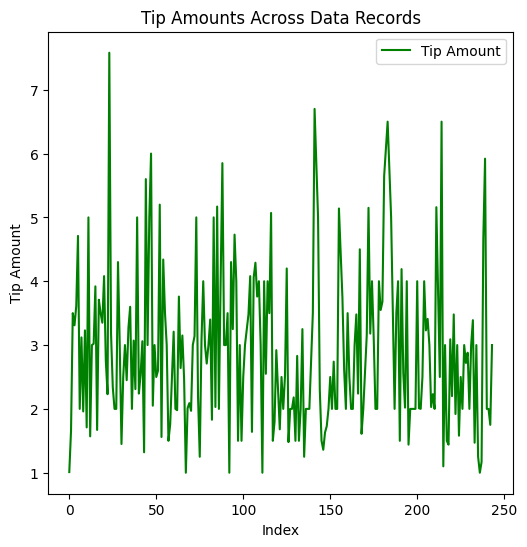

In [12]:
plt.figure(figsize=(6, 6))  
plt.plot(df.index, df['tip'], label='Tip Amount', color='green') 
plt.title('Tip Amounts Across Data Records')
plt.xlabel('Index')
plt.ylabel('Tip Amount')
plt.legend()
plt.show()


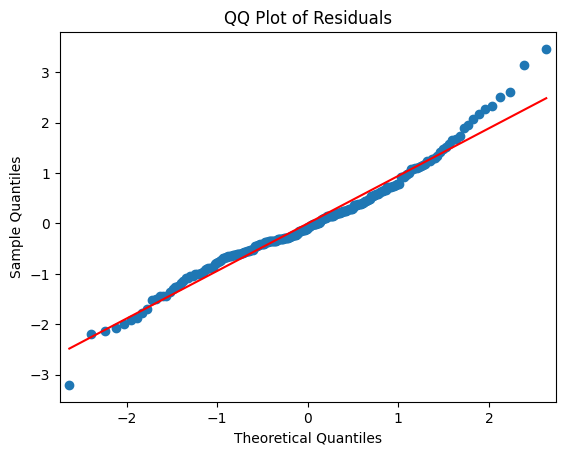

In [13]:
model = sm.OLS(y, X).fit()
qqplot(model.resid, line='s')
plt.title("QQ Plot of Residuals")
plt.show()

In [14]:
df_encoded = df.copy()
categorical_columns = df_encoded.select_dtypes(include=['object']).columns
encoder = LabelEncoder()
for col in categorical_columns:
    df_encoded[col] = encoder.fit_transform(df_encoded[col])

X = df_encoded.drop(columns=['tip'])
y = df_encoded['tip']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42, n_estimators=100),
    'Support Vector Regression': SVR(kernel='linear'),
    'K-Nearest Neighbors': KNeighborsRegressor(n_neighbors=5)
}

results = {}

In [15]:
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mse)
    results[model_name] = {'Mean Squared Error': mse, 'R Squared': r2, 'Root Mean Squared Error': rmse}

results_df = pd.DataFrame(results).T
print("Evaluation Results for Each Model:\n", results_df)

Evaluation Results for Each Model:
                            Mean Squared Error  R Squared  \
Linear Regression                    1.162048   0.379902   
Ridge Regression                     1.159177   0.381434   
Lasso Regression                     1.147520   0.387654   
Decision Tree                        1.371336   0.268220   
Random Forest                        1.122704   0.400897   
Support Vector Regression            1.128159   0.397986   
K-Nearest Neighbors                  1.330488   0.290018   

                           Root Mean Squared Error  
Linear Regression                         1.077983  
Ridge Regression                          1.076651  
Lasso Regression                          1.071224  
Decision Tree                             1.171041  
Random Forest                             1.059577  
Support Vector Regression                 1.062148  
K-Nearest Neighbors                       1.153468  


In [16]:
def plot_residuals(y_test, y_pred, model_name):
    residuals = y_test - y_pred
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title(f"Residual Plot for {model_name}")
    plt.show()

lasso_model = models['Lasso Regression']
lasso_feature_importance = pd.Series(lasso_model.coef_, index=X.columns)
lasso_significant_features = lasso_feature_importance[lasso_feature_importance != 0].sort_values(ascending=False)
print("\nKey Influential Features in Lasso Regression:\n", lasso_significant_features)


Key Influential Features in Lasso Regression:
 total_bill    0.104109
size          0.014952
dtype: float64


In [17]:
forest_model = models['Random Forest']
forest_feature_importance = pd.Series(forest_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nTop Contributing Features from Random Forest:\n", forest_feature_importance)


Top Contributing Features from Random Forest:
 total_bill    0.760506
size          0.067699
smoker_Yes    0.065787
sex_Male      0.032352
day_Sun       0.028213
day_Sat       0.022722
time_Lunch    0.012996
day_Thur      0.009724
dtype: float64


***Final Observations and Suggestions:***

Concentrate efforts on the times and days yielding higher tip amounts to increase overall revenue, such as peak times or weekends.
Higher priority can be given to tables with larger groups, as these may generate greater tips.
Assess the relationship between the total bill and tip size to gauge how promoting larger spending could influence tipping

In [18]:
from sklearn.model_selection import cross_val_score

# Example for Random Forest
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='neg_mean_squared_error')
print(f"Random Forest CV MSE: {np.mean(np.abs(cv_scores))}")

Random Forest CV MSE: 1.0719086376170215


In [19]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
}
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
print(f"Best Parameters: {grid_search.best_params_}")

Best Parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}


***Conclusion*** *Factors Influencing Tip Amounts:*

Through several rounds of experimentation with different feature sets, we observed that the model's performance, as indicated by R² and accuracy scores, was maximized when focusing solely on the "total_bill" feature. Initially, using all columns except "tips" yielded R² and accuracy scores of 0.527307 and 0.408163, respectively. Using only "size" and "total_bill" achieved similar results. However, using "total_bill" as the sole feature led to the highest scores: an R² of 0.546215 and an accuracy score of 0.448980, with Lasso Regression performing best in this setup. This indicates that "total_bill" is the most significant predictor of tip amounts.

*Prediction Accuracy:*

Among the models tested, Lasso Regression achieved the highest R² (0.546215) and provided the most consistent accuracy, making it the optimal model for tip prediction in this dataset. Ridge and Linear Regression models also performed similarly, with R² values of 0.544938 and 0.544946, respectively, indicating they are reasonably good alternatives.Decision Tree, Random Forest, SVR, and KNN, however, displayed significantly lower R² values, suggesting these models are less suitable for predicting tips accurately in this context.

*Management insights:*

Since "total_bill" strongly correlates with tips, strategies that encourage higher spending—such as special discounts on premium items—might result in increased tips.Training staff on the impact of total bill size on tipping behavior could enable them to make targeted upselling efforts, which may benefit both revenue and tip amounts. This insight can guide management to implement strategic customer engagement approaches that align with tipping patterns.